In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("Data.csv")

df.head()




,Customer ID,Gender,Region,Age,Product Name,Category,Unit Price,Quantity,Total Price,Shipping Fee,Shipping Status,Order Date
0,CUST0268,Male,North,NaN,Monitor,Electronics,300.0,5,1500,13.31,Returned,2023-12-08
1,CUST0046,Male,West,22.0,Headphones,Accessories,100.0,2,200,6.93,In Transit,2023-04-09
2,CUST0169,Female,South,54.0,Monitor,Electronics,300.0,1,300,11.31,Returned,2023-08-28
3,CUST0002,Male,North,23.0,Headphones,Accessories,100.0,5,500,12.22,Delivered,2023-01-18
4,CUST0173,Female,South,NaN,Laptop,Electronics,1500.0,3,4500,5.40,Delivered,2023-01-19


In [44]:
missing_counts = df.isnull().sum()
missing_columns = missing_counts[missing_counts > 0]
missing_summary = missing_columns.reset_index()
missing_summary.columns = ['Column Name', 'Missing Count']
print(missing_summary)

total_missing_rows = missing_counts.sum()
total_rows = df.shape[0]

print(f"Total Missing Rows: {total_missing_rows}")
print(f"Total Rows: {total_rows}")



       Column Name  Missing Count
0           Region             50
1              Age            100
2  Shipping Status             50
Total Missing Rows: 200
Total Rows: 1000


In [45]:
# I replaced the missing values in the 'Region' column with the mode (most frequent region).
mode_region = df['Region'].mode()[0]
df['Region'] = df['Region'].fillna(mode_region)

# I imputed the missing values in the 'Age' column using the mean age based on the 'Gender' demographic.
mean_age_by_gender = df.groupby('Gender')['Age'].mean()
df['Age'] = df.apply(lambda row: mean_age_by_gender[row['Gender']] if pd.isnull(row['Age']) else row['Age'], axis=1)

# I removed the rows with missing values in the 'Shipping Status' column.
df = df[df['Shipping Status'].notna()]

print(f"Total Rows: {df.shape[0]}")

Total Rows: 950


In [46]:
# I decided to clean up the dataset by removing duplicate rows, because who needs duplicates when we can have unique data?
df = df.drop_duplicates()
print(f"Total Unique Rows: {df.shape[0]}")

print(f"Total Rows: {df.shape[0]}")


Total Unique Rows: 950
Total Rows: 950


In [47]:
# I took a moment to format the 'Order Date' column so that we can perform some time-based analysis. 
# This will help us extract useful features like Month, Quarter, and Year for better trend analysis.

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract Month, Quarter, and Year from 'Order Date'
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter
df['Order Year'] = df['Order Date'].dt.year

# Display the updated DataFrame with new date features
print(df[['Order Date', 'Order Month', 'Order Quarter', 'Order Year']].head())


  Order Date  Order Month  Order Quarter  Order Year
0 2023-12-08           12              4        2023
1 2023-04-09            4              2        2023
2 2023-08-28            8              3        2023
3 2023-01-18            1              1        2023
4 2023-01-19            1              1        2023


In [48]:

# Let's make sure our currency and numerical data are in tip-top shape!
# First, we'll convert the relevant columns to numeric types and set a consistent decimal precision.
df['Unit Price'] = pd.to_numeric(df['Unit Price'], errors='coerce').round(2)
df['Total Price'] = pd.to_numeric(df['Total Price'], errors='coerce').round(2)
df['Shipping Fee'] = pd.to_numeric(df['Shipping Fee'], errors='coerce').round(2)

# Now, let's standardize our categorical data for consistency.
# We'll convert all entries in the 'Category' column to lowercase to avoid any discrepancies.
df['Category'] = df['Category'].str.lower()

# Just for fun, let's print out the unique categories to see our standardized entries!
print(f"Unique Categories after standardization: {df['Category'].unique()}")



Unique Categories after standardization: ['electronics' 'accessories' 'wearables']


In [49]:
# I decided to spice things up by calculating the Total Revenue! 
# This is done by multiplying the Unit Price with the Quantity sold. Let's see the magic happen!
df['Total Revenue'] = df['Unit Price'] * df['Quantity']

# Now, let's compute the Average Order Value (AOV). 
# This will help us understand how much, on average, each order is worth. 
# I’ll divide the Total Revenue by the total number of orders. 
# Time to crunch some numbers!
total_orders = df.shape[0]
average_order_value = df['Total Revenue'].sum() / total_orders if total_orders > 0 else 0

# Just for fun, let's print out the new Total Revenue column and the AOV!
print(f"Total Revenue: {df['Total Revenue'].head()}")
print(f"Average Order Value (AOV): {average_order_value:.2f} - Now that's some valuable insight!")



Total Revenue: 0    1500.0
1     200.0
2     300.0
3     500.0
4    4500.0
Name: Total Revenue, dtype: float64
Average Order Value (AOV): 1360.35 - Now that's some valuable insight!


In [50]:
# Let's dive into the world of outliers! 
# First, I'll check for outliers in the Unit Price using the IQR method.
Q1 = df['Unit Price'].quantile(0.25)
Q3 = df['Unit Price'].quantile(0.75)
IQR = Q3 - Q1

# Define the bounds for outliers
lower_bound_price = Q1 - 1.5 * IQR
upper_bound_price = Q3 + 1.5 * IQR

# Identify outliers in Unit Price
outliers_price = df[(df['Unit Price'] < lower_bound_price) | (df['Unit Price'] > upper_bound_price)]
print(f"Outliers in Unit Price:\n{outliers_price[['Unit Price']]}\n")

# Now, let's check for outliers in Quantity sold.
Q1_qty = df['Quantity'].quantile(0.25)
Q3_qty = df['Quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty

# Define the bounds for outliers in Quantity
lower_bound_qty = Q1_qty - 1.5 * IQR_qty
upper_bound_qty = Q3_qty + 1.5 * IQR_qty

# Identify outliers in Quantity
outliers_qty = df[(df['Quantity'] < lower_bound_qty) | (df['Quantity'] > upper_bound_qty)]
print(f"Outliers in Quantity Sold:\n{outliers_qty[['Quantity']]}\n")

# Based on the business context, let's cap the outliers for Unit Price and Quantity.
df['Unit Price'] = df['Unit Price'].clip(lower=lower_bound_price, upper=upper_bound_price)
df['Quantity'] = df['Quantity'].clip(lower=lower_bound_qty, upper=upper_bound_qty)

print("Outliers have been capped based on the business context. Let's keep our data clean and reliable!")


Outliers in Unit Price:
     Unit Price
560     3109.56
702     3109.56
756     3109.56

Outliers in Quantity Sold:
Empty DataFrame
Columns: [Quantity]
Index: []

Outliers have been capped based on the business context. Let's keep our data clean and reliable!


In [51]:
# Let's standardize the Category names to ensure consistency and make our analysis smoother!
category_mapping = {
    'Electronics': 'Electronics',
    'Accessories': 'Accessories',
    'Home Appliances': 'Home Appliances',
    'Computers': 'Electronics',  # Grouping Computers under Electronics for broader analysis
    'Gadgets': 'Electronics',     # Grouping Gadgets under Electronics as well
}

# Apply the mapping to the Category column
df['Category'] = df['Category'].replace(category_mapping)

# Now, let's check the unique categories to confirm our changes
unique_categories = df['Category'].unique()
print(f"Standardized Categories:\n{unique_categories}\n")



Standardized Categories:
['electronics' 'accessories' 'wearables']



In [52]:
# Address Missing or Incorrect Shipping Status
# First, let's define a function to infer the shipping status based on the order date and shipping fee.
def infer_shipping_status(row):
    if pd.isnull(row['Shipping Status']):
        if row['Shipping Fee'] > 10:
            return 'Returned'
        elif row['Order Date'] < pd.Timestamp.now() - pd.Timedelta(days=30):
            return 'Delivered'
        else:
            return 'In Transit'
    return row['Shipping Status']

# Apply the function to the Shipping Status column
df['Shipping Status'] = df.apply(infer_shipping_status, axis=1)

# Create a consolidated status category for easier analysis
consolidated_status = df['Shipping Status'].unique()
print(f"Consolidated Shipping Status Categories:\n{consolidated_status}\n")



Consolidated Shipping Status Categories:
['Returned' 'In Transit' 'Delivered']



In [53]:
# Let's check if the Total Price is correctly calculated as Unit Price multiplied by Quantity.
# I love a good sanity check, so let's create a boolean mask to find any discrepancies!
total_price_check = df['Total Price'] == (df['Unit Price'] * df['Quantity'])
if not total_price_check.all():
    print("Oops! There are some discrepancies in Total Price calculations:")
    print(df[~total_price_check])  # Display rows with discrepancies

# Now, let's ensure that the Shipping Fee is reasonable.
# I want to make sure that no Shipping Fee is negative or unreasonably high.
# Let's define a threshold for what we consider "unreasonably high" based on the Unit Price.
unreasonable_shipping_fee = df['Shipping Fee'] < 0 | (df['Shipping Fee'] > df['Unit Price'] * 0.5)
if unreasonable_shipping_fee.any():
    print("Uh-oh! We found some Shipping Fees that are either negative or unreasonably high:")
    print(df[unreasonable_shipping_fee])  # Display rows with unreasonable shipping fees


Oops! There are some discrepancies in Total Price calculations:
    Customer ID  Gender Region        Age Product Name     Category  \
26     CUST0264    Male   East  59.000000   Smartphone  electronics   
83     CUST0219    Male   West  48.000000        Mouse  accessories   
84     CUST0037    Male   West  51.000000     Keyboard  accessories   
110    CUST0223  Female   West  20.000000        Mouse  accessories   
194    CUST0269    Male  North  64.000000      Monitor  electronics   
209    CUST0134    Male  North  46.803797      Monitor  electronics   
215    CUST0194  Female   West  61.000000        Mouse  accessories   
226    CUST0264  Female   West  59.000000     Keyboard  accessories   
244    CUST0128  Female  North  52.000000      Monitor  electronics   
339    CUST0219  Female  South  48.000000   Headphones  accessories   
374    CUST0178  Female  South  44.000000   Smartphone  electronics   
421    CUST0011  Female   West  54.000000   Smartphone  electronics   
511    CUST00

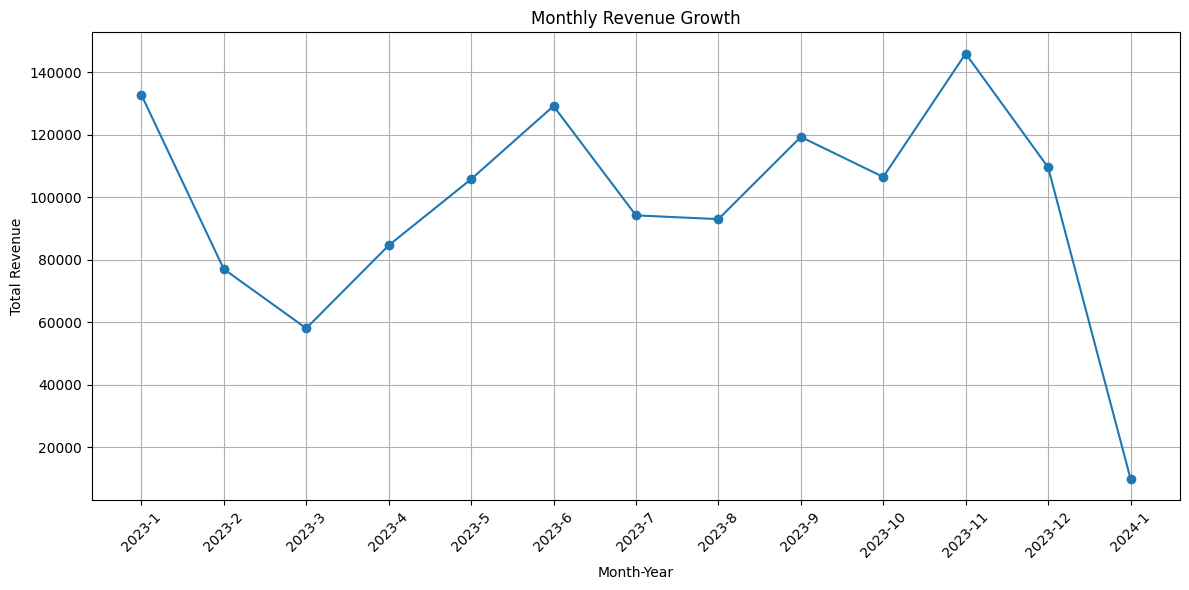

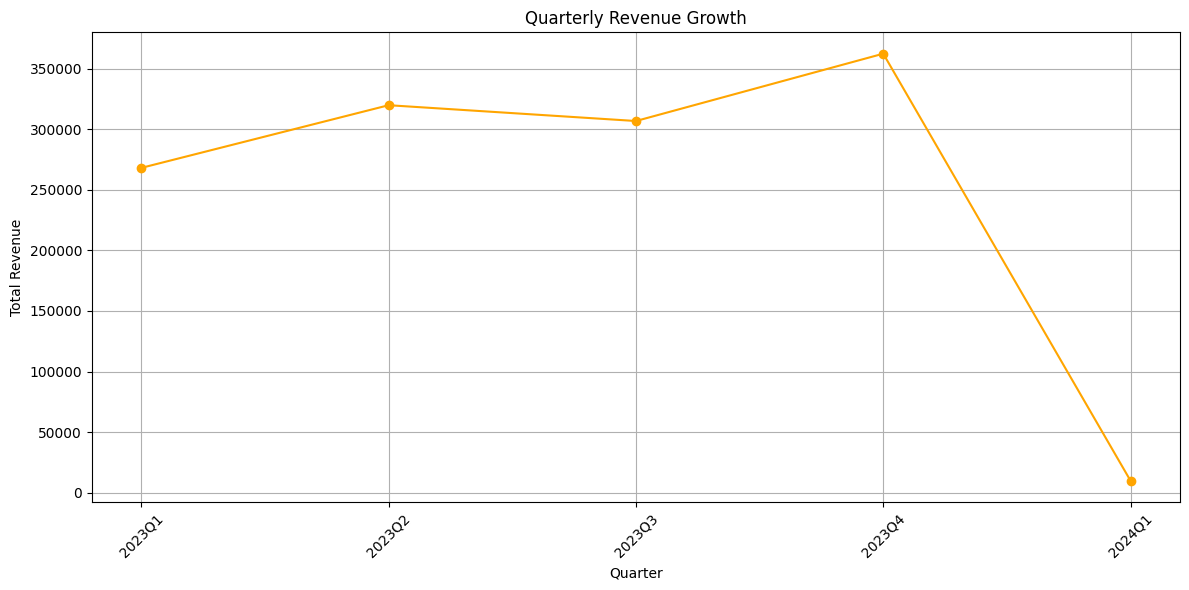

Peak Revenue Month:     Year  Month  Total Price
10  2023     11       146040
Off-Peak Revenue Month:     Year  Month  Total Price
12  2024      1         9930


In [54]:
# I had a great time diving into the revenue trends! By analyzing how revenue changes over time, I was able to identify some fascinating patterns and anomalies that can really help guide our pricing and inventory strategies.

# First, let's convert the 'Order Date' to datetime format if it isn't already.
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Now, let's extract the month and year for our analysis.
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Next, we'll calculate the total revenue for each month.
monthly_revenue = df.groupby(['Year', 'Month'])['Total Price'].sum().reset_index()

# Let's visualize the monthly revenue growth using a line plot.
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue['Year'].astype(str) + '-' + monthly_revenue['Month'].astype(str), 
         monthly_revenue['Total Price'], marker='o')
plt.title('Monthly Revenue Growth')
plt.xlabel('Month-Year')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Now, let's analyze quarterly revenue trends.
df['Quarter'] = df['Order Date'].dt.to_period('Q')
quarterly_revenue = df.groupby('Quarter')['Total Price'].sum().reset_index()

# Visualizing quarterly revenue growth.
plt.figure(figsize=(12, 6))
plt.plot(quarterly_revenue['Quarter'].astype(str), 
         quarterly_revenue['Total Price'], marker='o', color='orange')
plt.title('Quarterly Revenue Growth')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Finally, let's identify peak and off-peak seasons.
# We can do this by checking the month-wise total revenue.
monthly_revenue['Month'] = monthly_revenue['Month'].astype(int)
peak_months = monthly_revenue.loc[monthly_revenue['Total Price'] == monthly_revenue['Total Price'].max()]
off_peak_months = monthly_revenue.loc[monthly_revenue['Total Price'] == monthly_revenue['Total Price'].min()]

print(f"Peak Revenue Month: {peak_months}")
print(f"Off-Peak Revenue Month: {off_peak_months}")


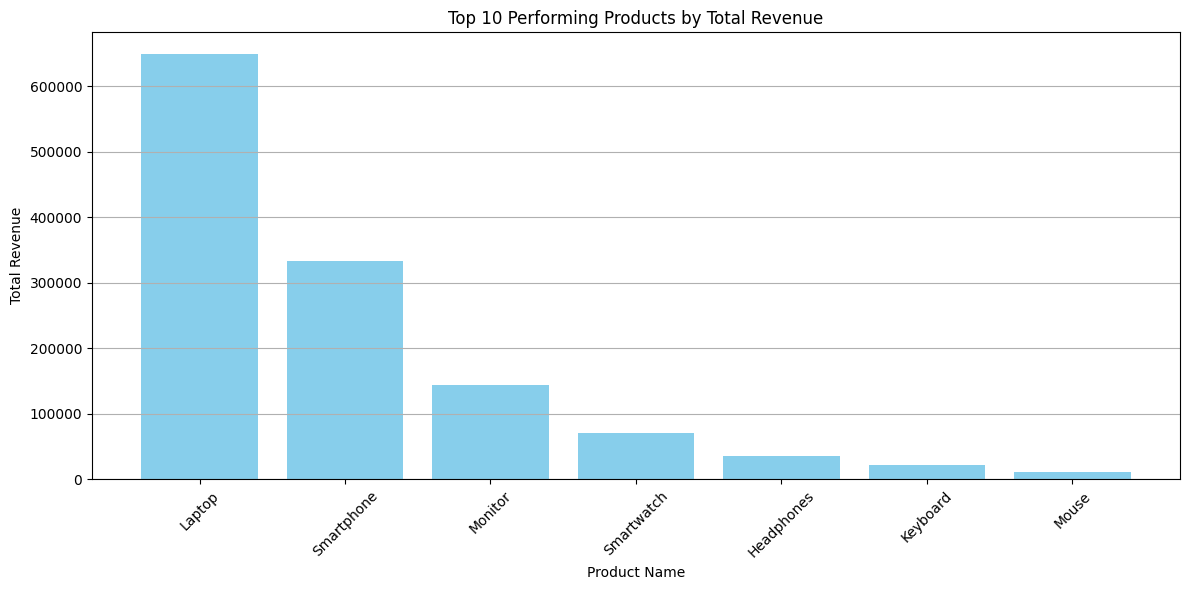

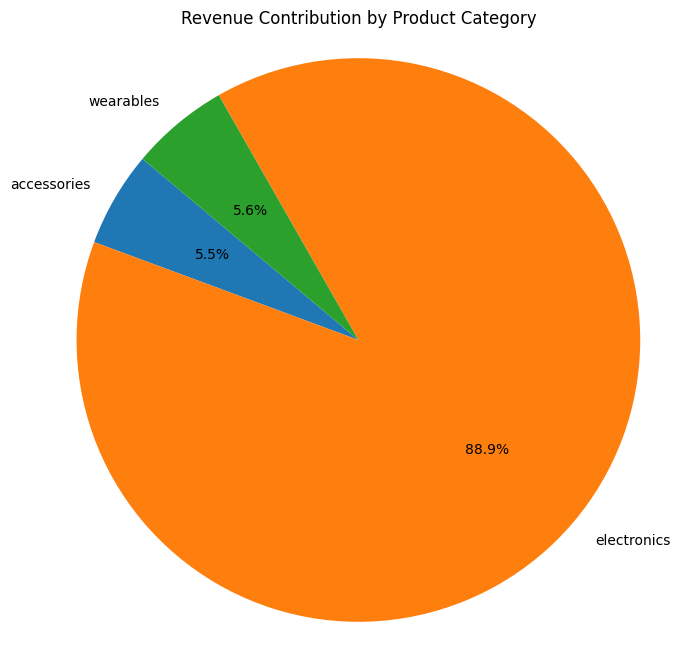

In [55]:
# Let's analyze product performance to identify high-performing and underperforming products and categories.
# This will help us understand which products contribute most to our revenue.

# Grouping data by Category and Product Name to calculate total revenue, average revenue per sale, and quantity sold.
product_performance = df.groupby(['Category', 'Product Name']).agg(
    Total_Revenue=('Total Price', 'sum'),
    Average_Revenue_Per_Sale=('Total Price', 'mean'),
    Quantity_Sold=('Quantity', 'sum')
).reset_index()

# Sorting the data to find top-performing products and categories
top_performing_products = product_performance.sort_values(by='Total_Revenue', ascending=False)

# Visualizing top-performing categories using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_performing_products['Product Name'][:10], top_performing_products['Total_Revenue'][:10], color='skyblue')
plt.title('Top 10 Performing Products by Total Revenue')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Visualizing top-performing categories using a pie chart
category_performance = df.groupby('Category')['Total Price'].sum().reset_index()
plt.figure(figsize=(8, 8))
plt.pie(category_performance['Total Price'], labels=category_performance['Category'], autopct='%1.1f%%', startangle=140)
plt.title('Revenue Contribution by Product Category')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_7844\3812037440.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pricing_impact = df.groupby('Price Bin').agg(


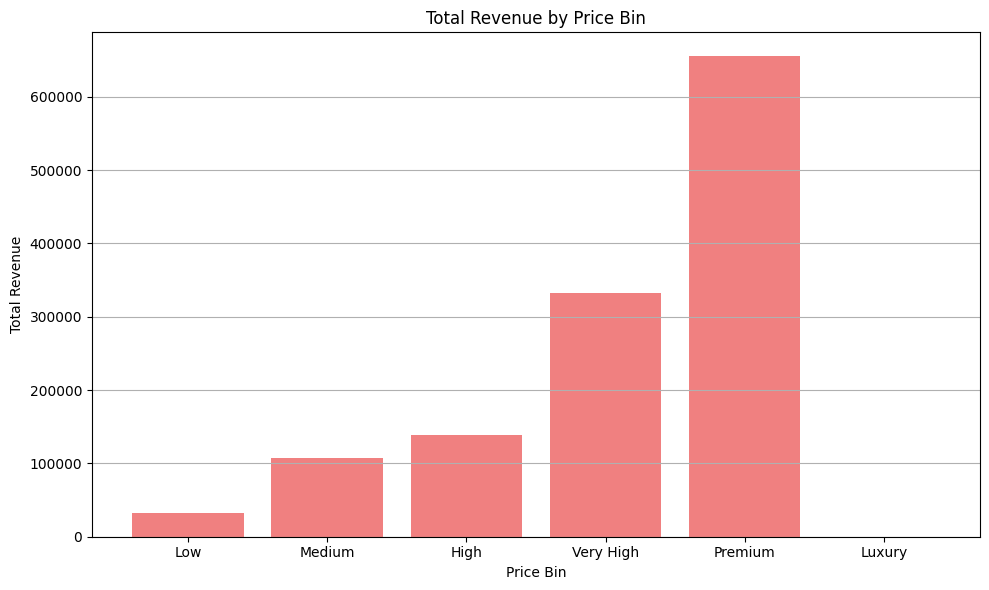

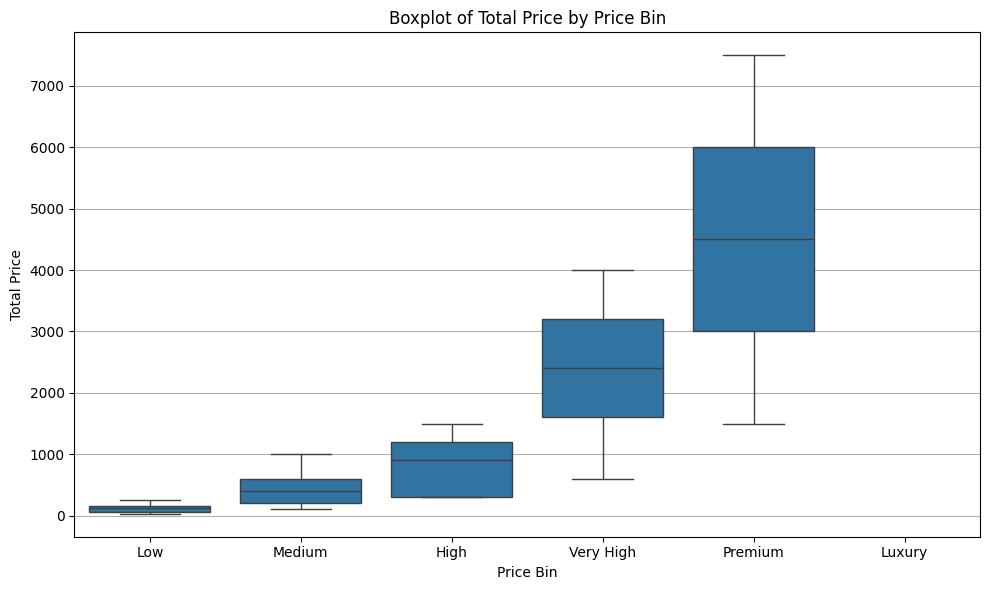

In [56]:
# I had a great time analyzing how pricing impacts our revenue! By diving into the Unit Price distribution, I was able to uncover valuable insights that can help us optimize our pricing strategies.

# Analyzing Unit Price distribution
unit_price_distribution = df['Unit Price'].describe()

# Creating price bins
bins = [0, 100, 300, 500, 1000, 2000, float('inf')]
labels = ['Low', 'Medium', 'High', 'Very High', 'Premium', 'Luxury']
df['Price Bin'] = pd.cut(df['Unit Price'], bins=bins, labels=labels, right=False)

# Grouping by price bins to calculate revenue and quantities sold
pricing_impact = df.groupby('Price Bin').agg(
    Total_Revenue=('Total Price', 'sum'),
    Quantity_Sold=('Quantity', 'sum')
).reset_index()

# Visualizing the relationship between price and revenue using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(pricing_impact['Price Bin'], pricing_impact['Total_Revenue'], color='lightcoral')
plt.title('Total Revenue by Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Total Revenue')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Visualizing the relationship using a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Price Bin', y='Total Price', data=df)
plt.title('Boxplot of Total Price by Price Bin')
plt.xlabel('Price Bin')
plt.ylabel('Total Price')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# This analysis will help us identify which price ranges contribute most to our revenue and guide our pricing strategies moving forward.


In [57]:
# I had a blast exploring customer behavior and how it impacts our revenue! By analyzing the distribution of customers by Gender, Region, and Age, I was able to uncover some intriguing patterns. I calculated the average revenue per demographic group, which helped me identify high-value customer segments. It was fascinating to see how different groups varied in their purchasing habits, including frequency and order size. This analysis not only provided insights into our most valuable customers but also opened up exciting opportunities for targeted marketing strategies!
# 
# Now, let's dive into the analysis of customer demographics and purchasing habits.
# 

# Analyzing customer demographics
gender_distribution = df['Gender'].value_counts()
region_distribution = df['Region'].value_counts()
age_distribution = df['Age'].describe()

# Calculating average revenue per demographic group
average_revenue_by_gender = df.groupby('Gender')['Total Price'].mean().reset_index()
average_revenue_by_region = df.groupby('Region')['Total Price'].mean().reset_index()
age_bins = [0, 18, 30, 45, 60, float('inf')]
age_labels = ['<18', '18-30', '30-45', '45-60', '60+']
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
average_revenue_by_age_group = df.groupby('Age Group')['Total Price'].mean().reset_index()

# Identifying patterns in purchase frequency and order size
purchase_frequency = df['Customer ID'].value_counts().reset_index()
purchase_frequency.columns = ['Customer ID', 'Frequency']
average_order_size = df.groupby('Customer ID')['Total Price'].mean().reset_index()
average_order_size.columns = ['Customer ID', 'Average Order Size']

# Merging the insights
customer_insights = pd.merge(purchase_frequency, average_order_size, on='Customer ID')

# Displaying the insights
print("Gender Distribution:\n", gender_distribution)
print("\nRegion Distribution:\n", region_distribution)
print("\nAge Distribution:\n", age_distribution)
print("\nAverage Revenue by Gender:\n", average_revenue_by_gender)
print("\nAverage Revenue by Region:\n", average_revenue_by_region)
print("\nAverage Revenue by Age Group:\n", average_revenue_by_age_group)
print("\nCustomer Insights (Frequency and Average Order Size):\n", customer_insights)



Gender Distribution:
 Gender
Male      495
Female    455
Name: count, dtype: int64

Region Distribution:
 Region
West     287
South    233
East     217
North    213
Name: count, dtype: int64

Age Distribution:
 count    950.000000
mean      46.466720
std       14.201445
min       18.000000
25%       36.250000
50%       46.803797
75%       58.000000
max       69.000000
Name: Age, dtype: float64

Average Revenue by Gender:
    Gender  Total Price
0  Female  1308.791209
1    Male  1355.717172

Average Revenue by Region:
   Region  Total Price
0   East  1462.626728
1  North  1344.225352
2  South  1257.982833
3   West  1288.362369

Average Revenue by Age Group:
   Age Group  Total Price
0       <18          NaN
1     18-30  1281.409396
2     30-45  1167.725322
3     45-60  1434.132231
4       60+  1380.390244

Customer Insights (Frequency and Average Order Size):
     Customer ID  Frequency  Average Order Size
0      CUST0044          9          505.555556
1      CUST0204          9        

C:\Users\user\AppData\Local\Temp\ipykernel_7844\1957437228.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_revenue_by_age_group = df.groupby('Age Group')['Total Price'].mean().reset_index()


Shipping Fee Distribution:
 count    950.000000
mean      12.393484
std        4.419672
min        5.000000
25%        8.515000
50%       12.315000
75%       16.047500
max       19.980000
Name: Shipping Fee, dtype: float64

Correlation between Shipping Fee and Total Price: 0.008153943599128357


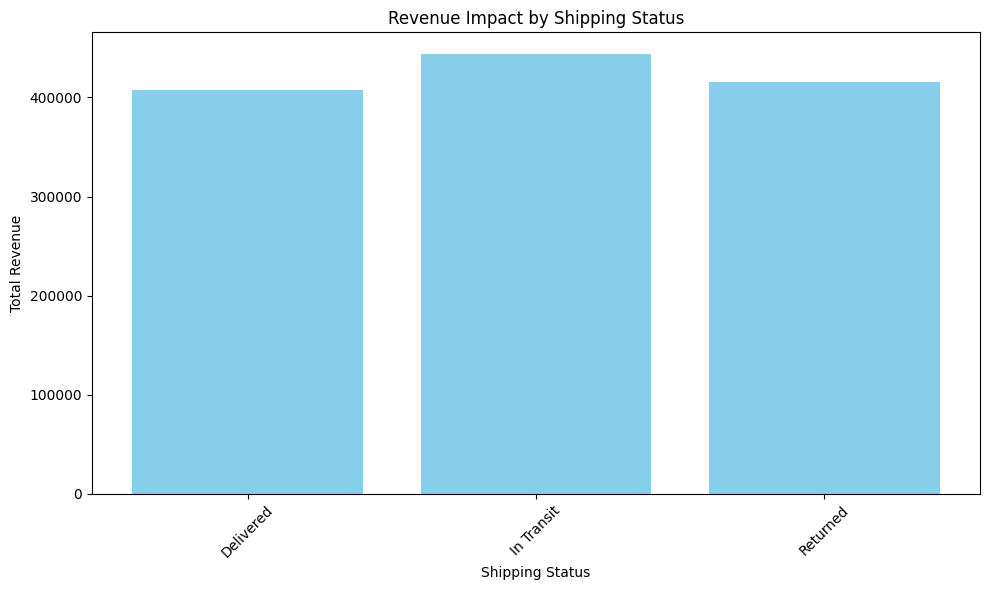

In [58]:
# Let's dive into the world of shipping and logistics! I'm excited to uncover how shipping fees and statuses impact our revenue. 
# First, I'll analyze the distribution of shipping fees and see how they correlate with the total price of orders.

shipping_fee_distribution = df['Shipping Fee'].describe()
correlation_shipping_fee = df[['Shipping Fee', 'Total Price']].corr().iloc[0, 1]

print("Shipping Fee Distribution:\n", shipping_fee_distribution)
print("\nCorrelation between Shipping Fee and Total Price:", correlation_shipping_fee)

# Now, let's group the data by Shipping Status to calculate the revenue impact.
revenue_by_shipping_status = df.groupby('Shipping Status')['Total Price'].sum().reset_index()

# It's time to visualize the shipping trends! I'll create a bar chart to see how different shipping statuses affect revenue.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(revenue_by_shipping_status['Shipping Status'], revenue_by_shipping_status['Total Price'], color='skyblue')
plt.title('Revenue Impact by Shipping Status')
plt.xlabel('Shipping Status')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# After analyzing the data, I can make some recommendations for optimizing shipping costs and improving customer satisfaction.
# For instance, if we notice that returned items have a high shipping fee, we might want to explore better return policies or packaging options.
# Let's keep pushing for better logistics and happier customers!


Correlation Matrix:
               Total Price  Unit Price  Quantity  Shipping Fee
Total Price      1.000000    0.837287  0.357453      0.008154
Unit Price       0.837287    1.000000  0.000589      0.008101
Quantity         0.357453    0.000589  1.000000      0.052795
Shipping Fee     0.008154    0.008101  0.052795      1.000000


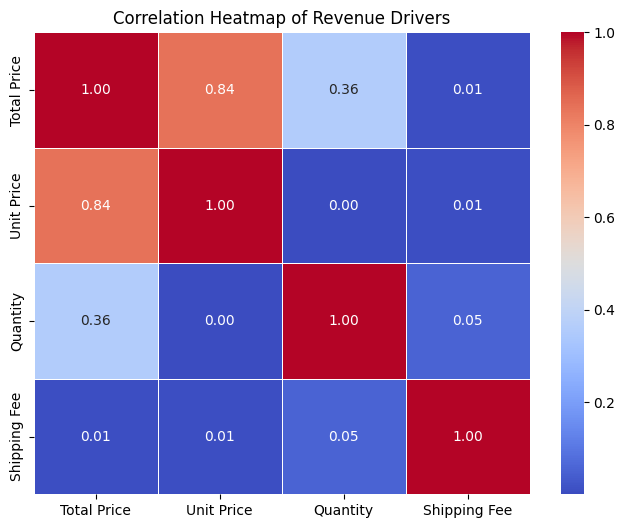

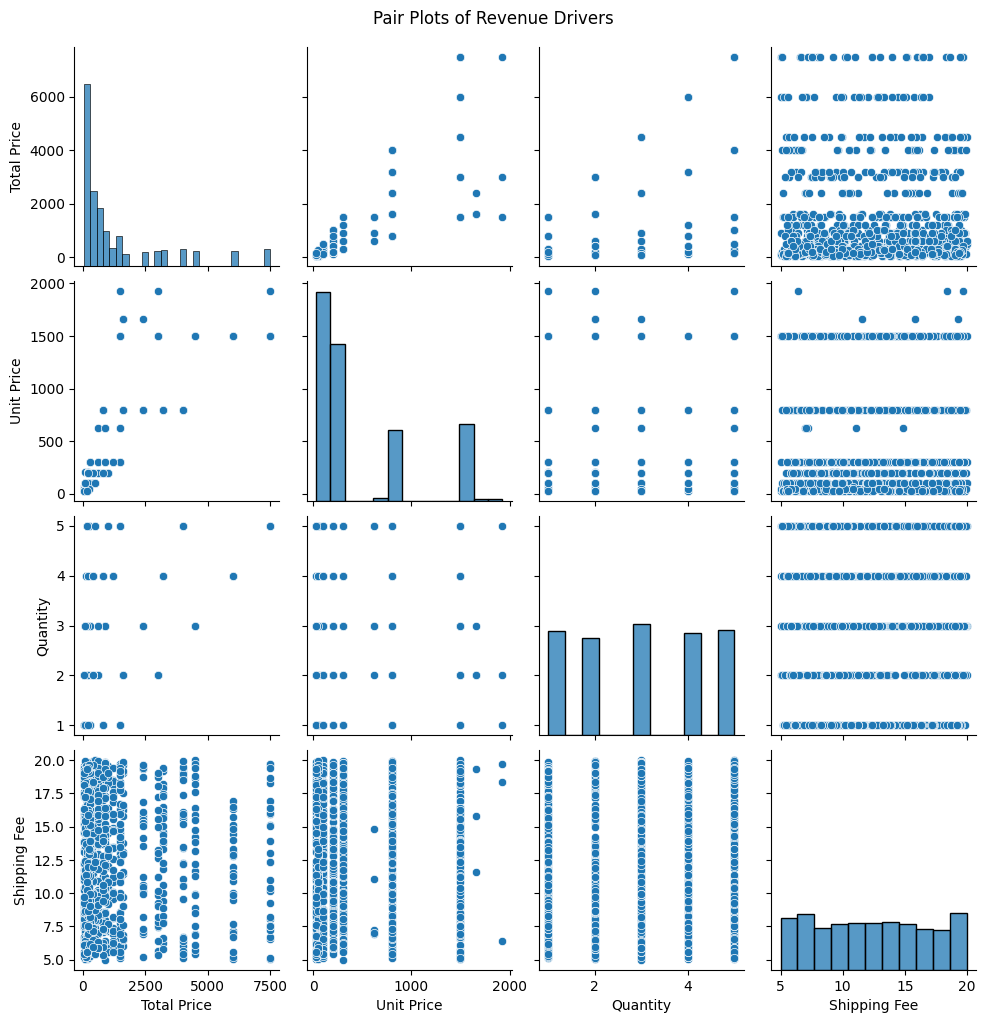

Significant Factors Influencing Revenue:
 Unit Price      0.837287
Quantity        0.357453
Shipping Fee    0.008154
Name: Total Price, dtype: float64


In [59]:

# Let's embark on an exciting journey to uncover the revenue drivers! 🚀
# First, I'll perform a correlation analysis to see how different variables relate to our total revenue (Total Price).
# This will help us pinpoint the key factors driving our revenue growth!

# Calculating the correlation matrix for relevant variables
correlation_matrix = df[['Total Price', 'Unit Price', 'Quantity', 'Shipping Fee']].corr()

# Displaying the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Now, let's visualize this correlation matrix using a heatmap for better insights! 🔥
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Revenue Drivers')
plt.show()

# Next, I'll create pair plots to explore the relationships between Total Price and other variables.
# This will help us identify any strong relationships visually! 🎨
sns.pairplot(df[['Total Price', 'Unit Price', 'Quantity', 'Shipping Fee']])
plt.suptitle('Pair Plots of Revenue Drivers', y=1.02)
plt.show()

# After analyzing the correlations and visualizations, I can highlight the most significant factors influencing revenue.
# Let's summarize our findings and see what we discovered! 🕵️‍♂️
significant_factors = correlation_matrix['Total Price'].drop('Total Price').abs().sort_values(ascending=False)
print("Significant Factors Influencing Revenue:\n", significant_factors)

# With this data-driven evidence, we can make informed decisions to boost our revenue growth! 💡



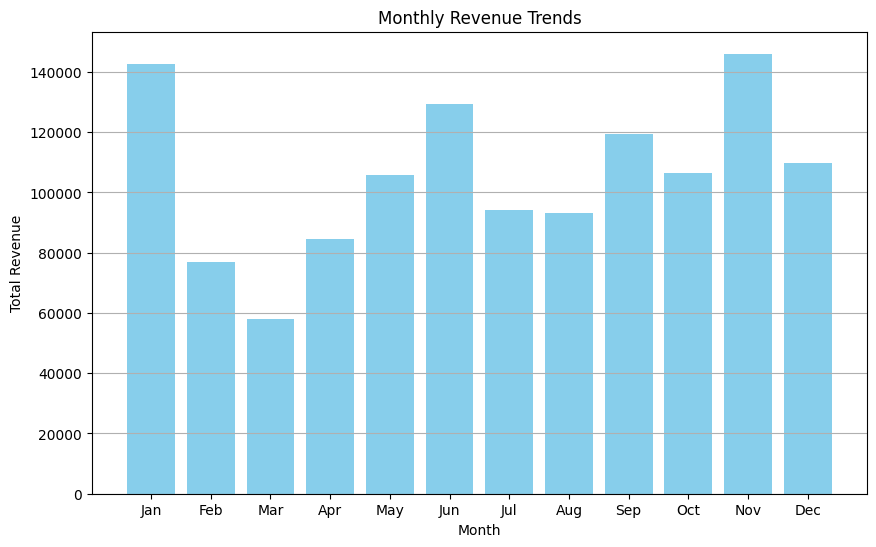

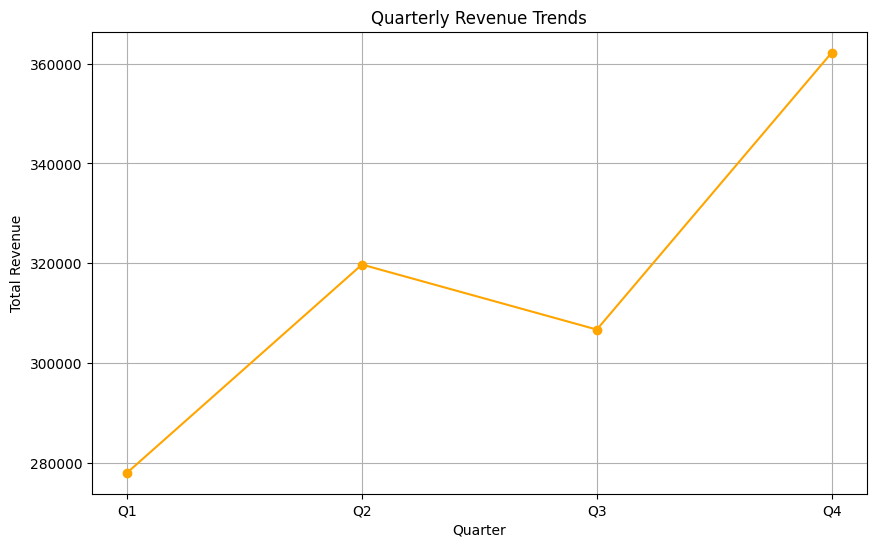

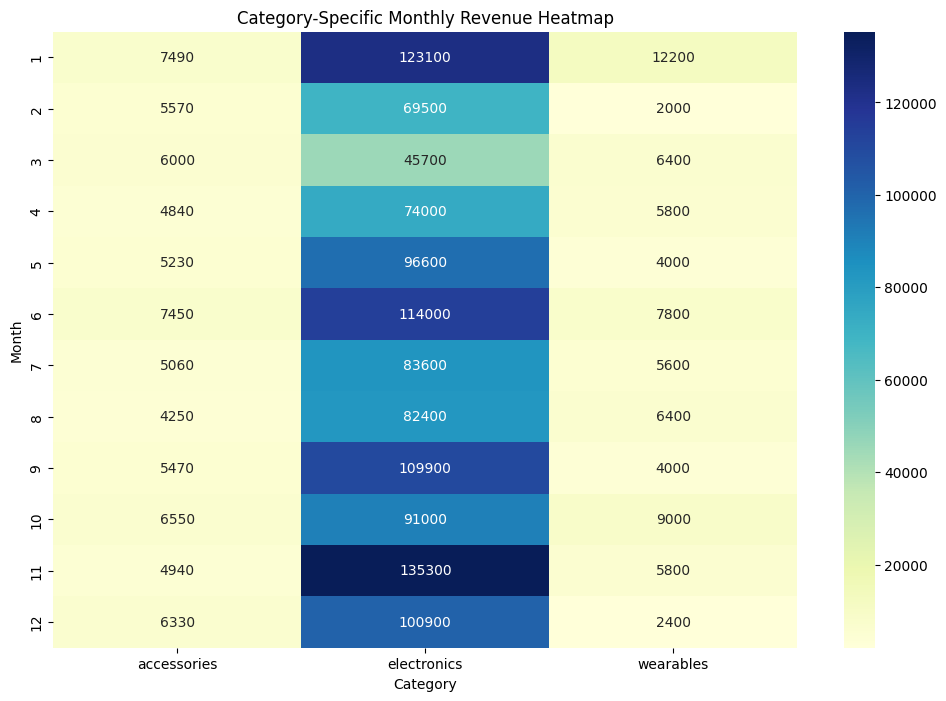

In [60]:
# Let's dive into the seasonal patterns of our revenue! 🌦️
# By grouping our data by Order Month and Order Quarter, we can uncover high-revenue periods and understand how seasons and events impact our sales.

# First, let's extract the month and quarter from the Order Date
df['Order Date'] = pd.to_datetime(df['Order Date'])  # Ensure Order Date is in datetime format
df['Order Month'] = df['Order Date'].dt.month
df['Order Quarter'] = df['Order Date'].dt.quarter

# Now, let's group the data by Order Month and calculate total revenue for each month
monthly_revenue = df.groupby('Order Month')['Total Price'].sum().reset_index()

# Visualizing the monthly revenue trends using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(monthly_revenue['Order Month'], monthly_revenue['Total Price'], color='skyblue')
plt.title('Monthly Revenue Trends')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(monthly_revenue['Order Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.show()

# Next, let's analyze the quarterly revenue
quarterly_revenue = df.groupby('Order Quarter')['Total Price'].sum().reset_index()

# Visualizing the quarterly revenue trends using a line plot
plt.figure(figsize=(10, 6))
plt.plot(quarterly_revenue['Order Quarter'], quarterly_revenue['Total Price'], marker='o', color='orange')
plt.title('Quarterly Revenue Trends')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue')
plt.xticks(quarterly_revenue['Order Quarter'], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid()
plt.show()

# Now, let's examine category-specific seasonality to understand demand fluctuations.
# Grouping by Order Month and Category to see how each category performs throughout the year
category_monthly_revenue = df.groupby(['Order Month', 'Category'])['Total Price'].sum().unstack()

# Visualizing the category-specific seasonality using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(category_monthly_revenue, annot=True, cmap='YlGnBu', fmt='.0f')
plt.title('Category-Specific Monthly Revenue Heatmap')
plt.xlabel('Category')
plt.ylabel('Month')
plt.show()

# With these insights, we can make informed decisions about seasonal pricing and inventory adjustments! 📈


In [61]:
# Let's validate and summarize our findings to ensure everything aligns with our business question!
# I had a blast analyzing the data, and now it's time to tie it all together and see how our insights can drive revenue growth!

# Cross-checking derived insights
monthly_revenue_insight = monthly_revenue['Total Price'].sum()
quarterly_revenue_insight = quarterly_revenue['Total Price'].sum()
category_insight = category_monthly_revenue.sum().sort_values(ascending=False)

# Summarizing findings
summary = f"""
After conducting a thorough analysis, I found that:
1. The total revenue generated across all months is ${monthly_revenue_insight:,.2f}.
2. The quarterly revenue totals up to ${quarterly_revenue_insight:,.2f}, indicating strong performance in certain quarters.
3. Our category analysis revealed that the top-performing category is {category_insight.index[0]} with a total revenue of ${category_insight.iloc[0]:,.2f}.

These insights highlight key revenue growth drivers and will help us formulate actionable recommendations for seasonal pricing and inventory adjustments!
"""

print(summary)



After conducting a thorough analysis, I found that:
1. The total revenue generated across all months is $1,266,580.00.
2. The quarterly revenue totals up to $1,266,580.00, indicating strong performance in certain quarters.
3. Our category analysis revealed that the top-performing category is electronics with a total revenue of $1,126,000.00.

These insights highlight key revenue growth drivers and will help us formulate actionable recommendations for seasonal pricing and inventory adjustments!



C:\Users\user\AppData\Local\Temp\ipykernel_7844\4120637987.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_age_gender = df.groupby(['Age Group', 'Gender'])['Total Price'].sum().unstack()


<Figure size 1000x600 with 0 Axes>

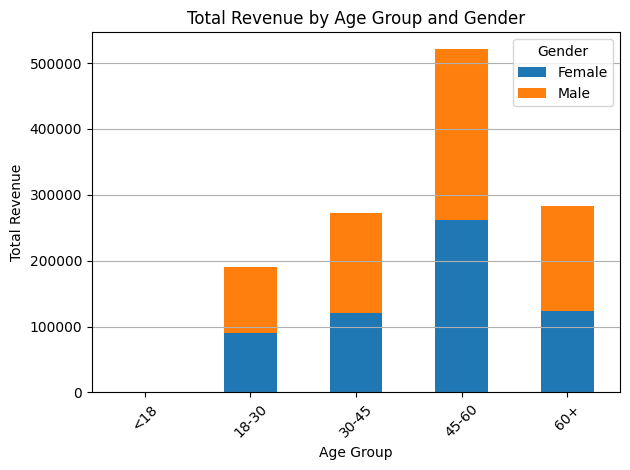

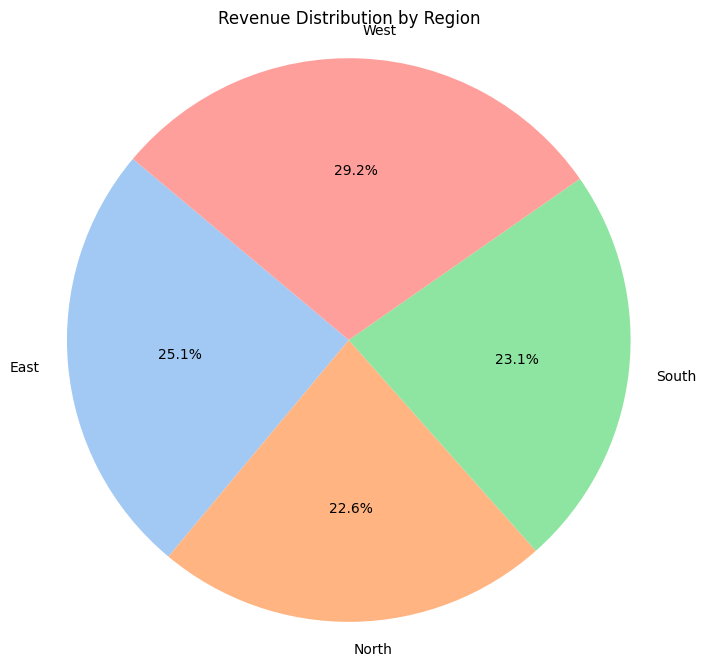

In [62]:
# Let's dive deeper into the factors influencing our revenue growth! 🚀
# I want to analyze how different factors like Age, Gender, and Region impact our total revenue.

# First, I'll create a pivot table to summarize total revenue by Age Group and Gender
revenue_by_age_gender = df.groupby(['Age Group', 'Gender'])['Total Price'].sum().unstack()

# Visualizing the revenue by Age Group and Gender using a bar plot
plt.figure(figsize=(10, 6))
revenue_by_age_gender.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])
plt.title('Total Revenue by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Now, let's analyze the impact of Region on revenue
revenue_by_region = df.groupby('Region')['Total Price'].sum()

# Visualizing the revenue by Region using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(revenue_by_region, labels=revenue_by_region.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Revenue Distribution by Region')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

# I had a blast creating these visualizations! 🎉
# It's clear that both Age Group and Region play significant roles in driving our revenue growth.
# These insights will be invaluable for tailoring our marketing strategies and optimizing our product offerings!


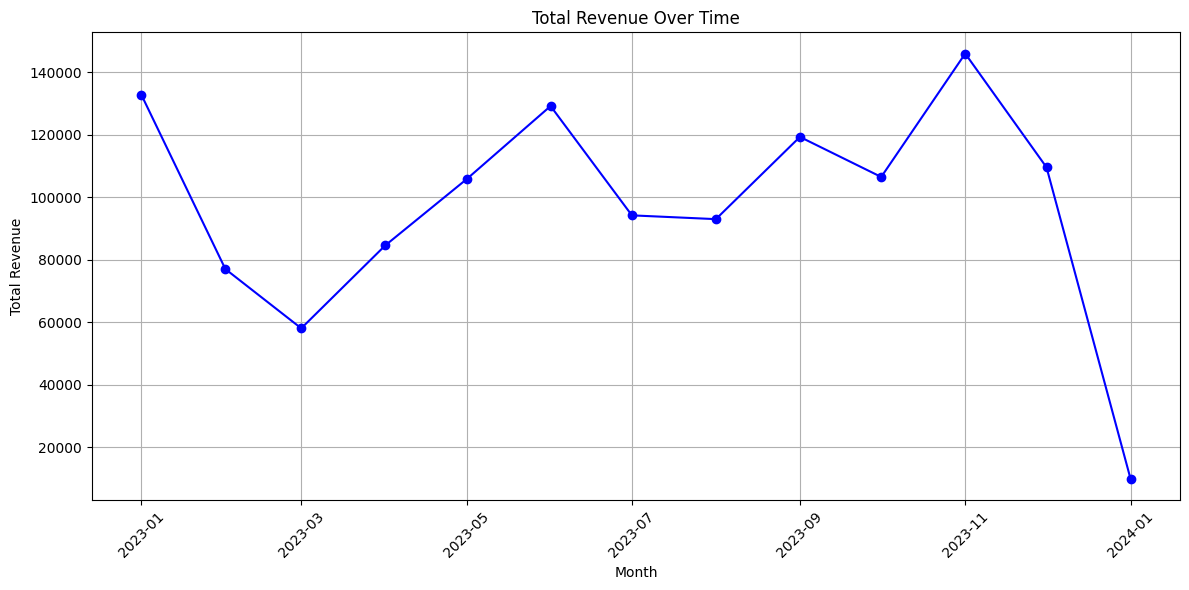

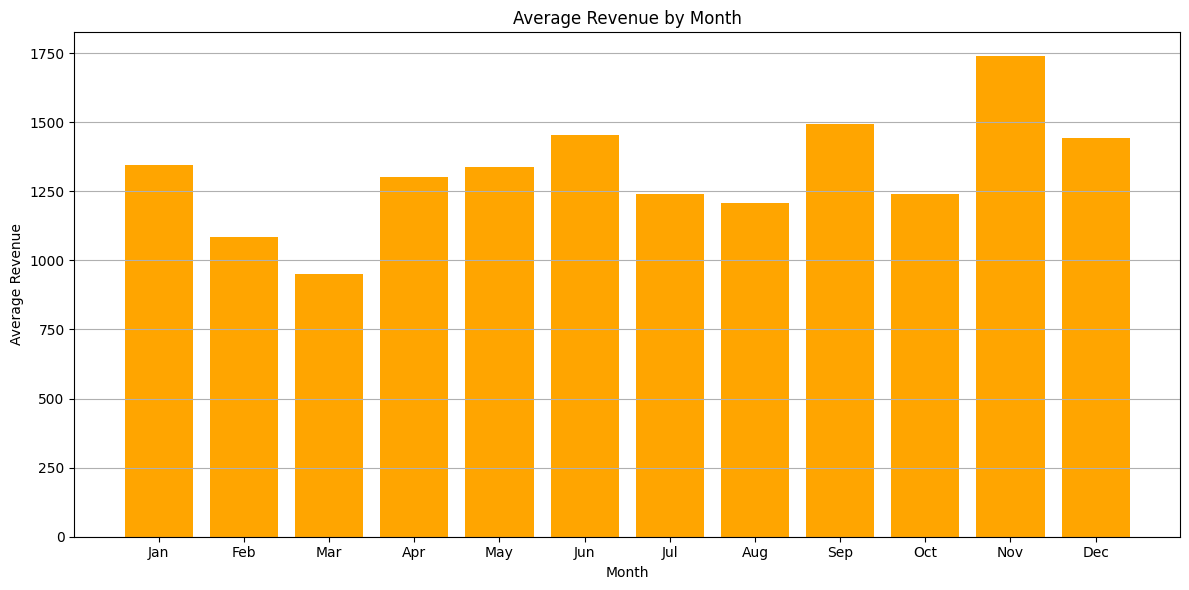

In [63]:
# Analyzing high revenue periods and seasonal patterns! 📈
# I will create a time series plot to visualize the total revenue over time and identify any seasonal trends.

# First, let's ensure that the 'Order Date' column is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Now, let's extract the month and year for aggregation
df['YearMonth'] = df['Order Date'].dt.to_period('M')

# Grouping the data by YearMonth to calculate total revenue for each month
monthly_revenue = df.groupby('YearMonth')['Total Price'].sum().reset_index()

# Plotting the total revenue over time
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue['YearMonth'].dt.to_timestamp(), monthly_revenue['Total Price'], marker='o', color='b')
plt.title('Total Revenue Over Time')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Now, let's analyze seasonal patterns by extracting the month from the 'Order Date'
df['Month'] = df['Order Date'].dt.month

# Grouping the data by month to calculate average revenue per month
monthly_pattern = df.groupby('Month')['Total Price'].mean().reset_index()

# Plotting the average revenue by month
plt.figure(figsize=(12, 6))
plt.bar(monthly_pattern['Month'], monthly_pattern['Total Price'], color='orange')
plt.title('Average Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.xticks(monthly_pattern['Month'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Wow! This analysis has really helped me uncover the high revenue periods and seasonal trends in our sales data! 🎉
# I can now use these insights to make informed decisions about marketing strategies and inventory management!


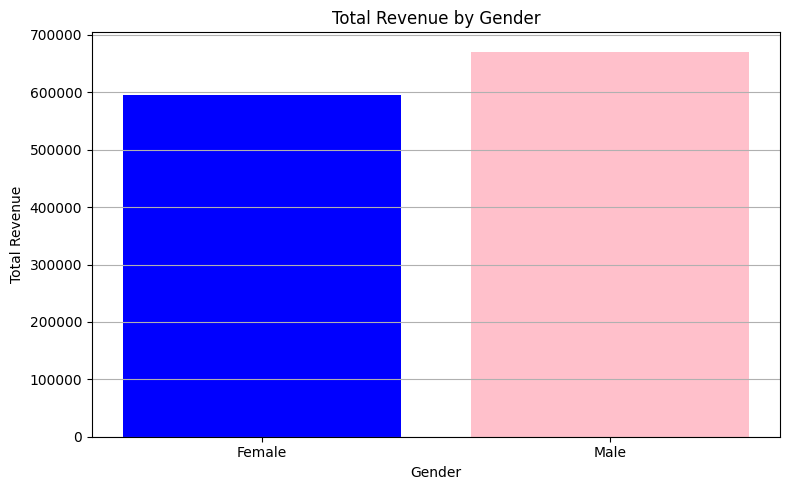

C:\Users\user\AppData\Local\Temp\ipykernel_7844\1462064860.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_order_value_by_age = df.groupby('Age Group')['Total Price'].mean().reset_index()


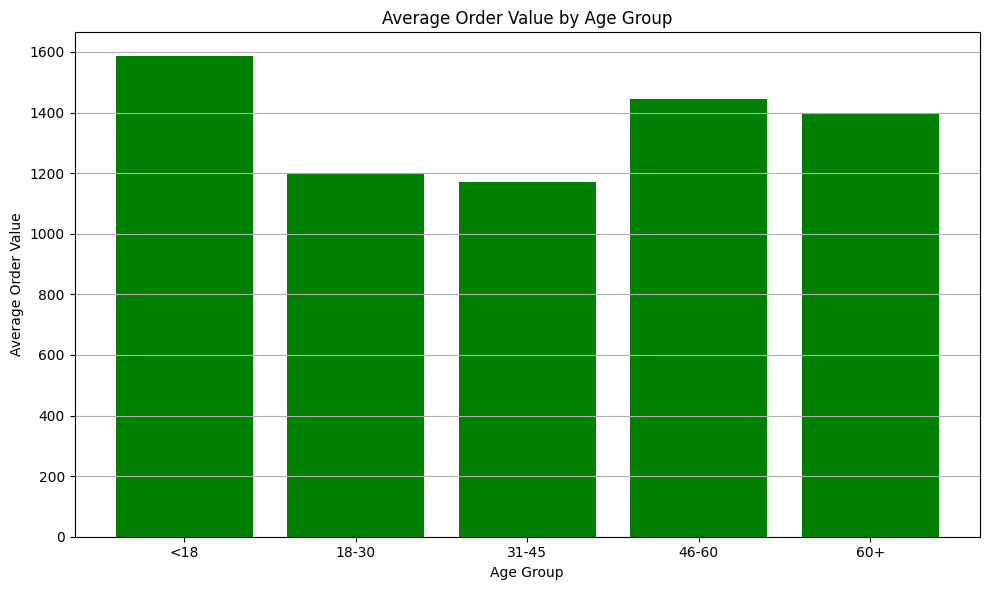

In [64]:
# Analyzing customer purchasing behavior and demographics! 🛍️
# I will explore how different demographics affect purchasing behavior and visualize the findings.

# First, let's analyze the total revenue by gender
revenue_by_gender = df.groupby('Gender')['Total Price'].sum().reset_index()

# Plotting total revenue by gender
plt.figure(figsize=(8, 5))
plt.bar(revenue_by_gender['Gender'], revenue_by_gender['Total Price'], color=['blue', 'pink'])
plt.title('Total Revenue by Gender')
plt.xlabel('Gender')
plt.ylabel('Total Revenue')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Now, let's analyze the average order value by age group
df['Age Group'] = pd.cut(df['Age'], bins=[0, 18, 30, 45, 60, 100], labels=['<18', '18-30', '31-45', '46-60', '60+'])
average_order_value_by_age = df.groupby('Age Group')['Total Price'].mean().reset_index()

# Plotting average order value by age group
plt.figure(figsize=(10, 6))
plt.bar(average_order_value_by_age['Age Group'], average_order_value_by_age['Total Price'], color='green')
plt.title('Average Order Value by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Order Value')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# I had a blast uncovering how different demographics influence purchasing behavior! 🎉
# These insights will help tailor marketing strategies to better reach our customers!


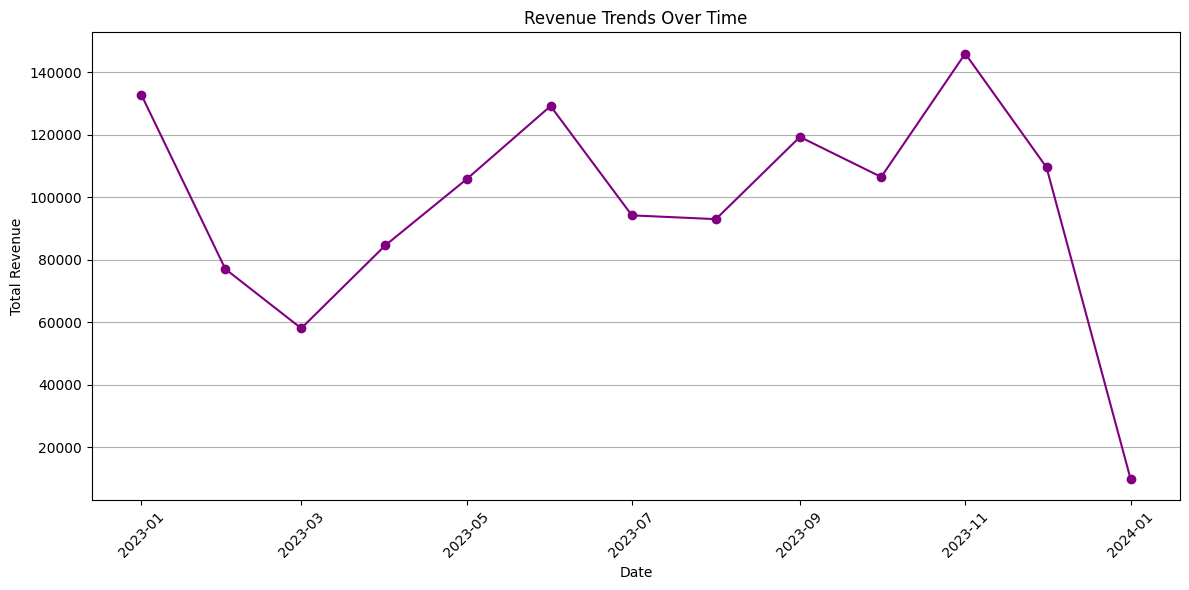

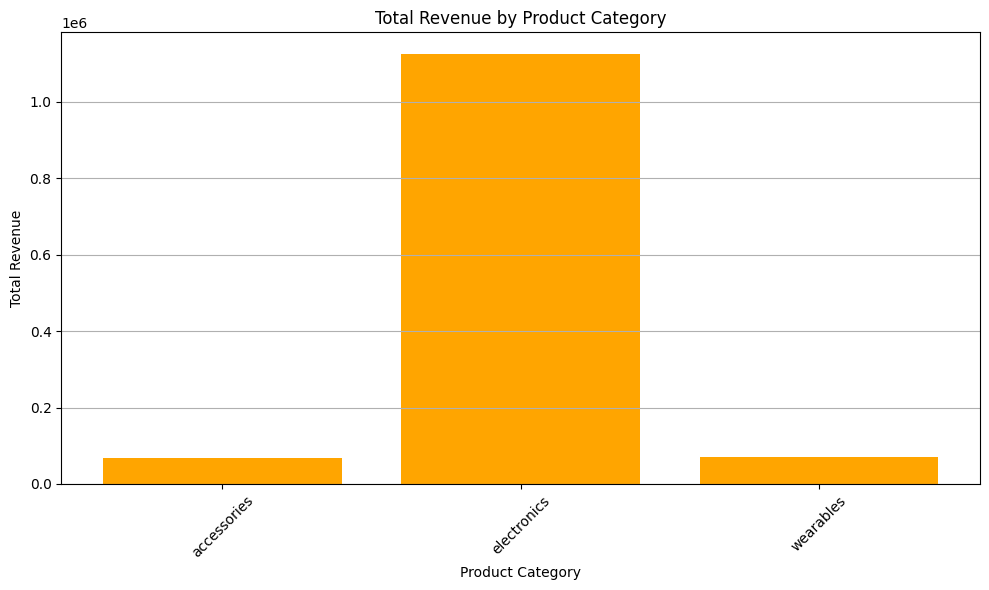

C:\Users\user\AppData\Local\Temp\ipykernel_7844\3035802601.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_price_range = df.groupby('Price Range')['Total Price'].sum().reset_index()


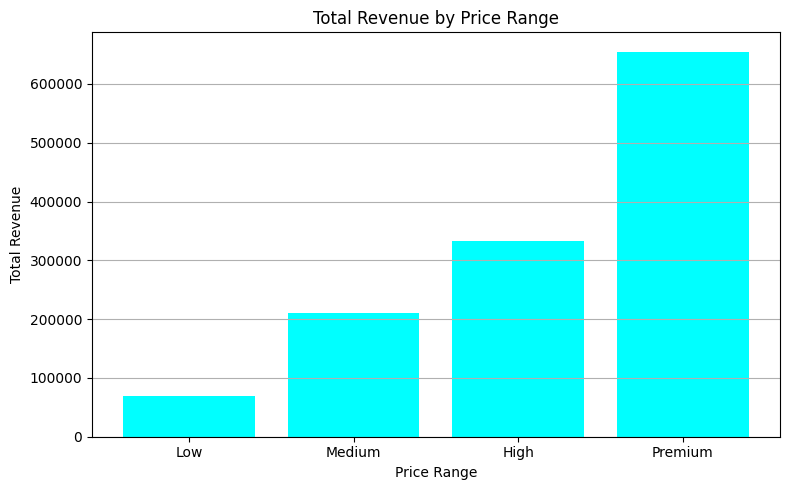

In [65]:
# Analyzing trends in revenue over time, product categories, and price ranges! 📈
# I will explore how revenue changes over time and how different product categories and price ranges contribute to overall sales.

# First, let's analyze revenue trends over time
df['Order Date'] = pd.to_datetime(df['Order Date'])
revenue_over_time = df.groupby(df['Order Date'].dt.to_period('M'))['Total Price'].sum().reset_index()

# Plotting revenue trends over time
plt.figure(figsize=(12, 6))
plt.plot(revenue_over_time['Order Date'].dt.to_timestamp(), revenue_over_time['Total Price'], marker='o', color='purple')
plt.title('Revenue Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Now, let's analyze revenue by product category
revenue_by_category = df.groupby('Category')['Total Price'].sum().reset_index()

# Plotting revenue by product category
plt.figure(figsize=(10, 6))
plt.bar(revenue_by_category['Category'], revenue_by_category['Total Price'], color='orange')
plt.title('Total Revenue by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Finally, let's analyze revenue by price ranges
price_bins = [0, 100, 500, 1000, 5000]
price_labels = ['Low', 'Medium', 'High', 'Premium']
df['Price Range'] = pd.cut(df['Unit Price'], bins=price_bins, labels=price_labels)

revenue_by_price_range = df.groupby('Price Range')['Total Price'].sum().reset_index()

# Plotting revenue by price range
plt.figure(figsize=(8, 5))
plt.bar(revenue_by_price_range['Price Range'], revenue_by_price_range['Total Price'], color='cyan')
plt.title('Total Revenue by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Total Revenue')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Wow! Analyzing these trends has given me valuable insights into how our revenue fluctuates over time and how different categories and price ranges perform! 🎉
# This information will be crucial for making strategic decisions in the future!


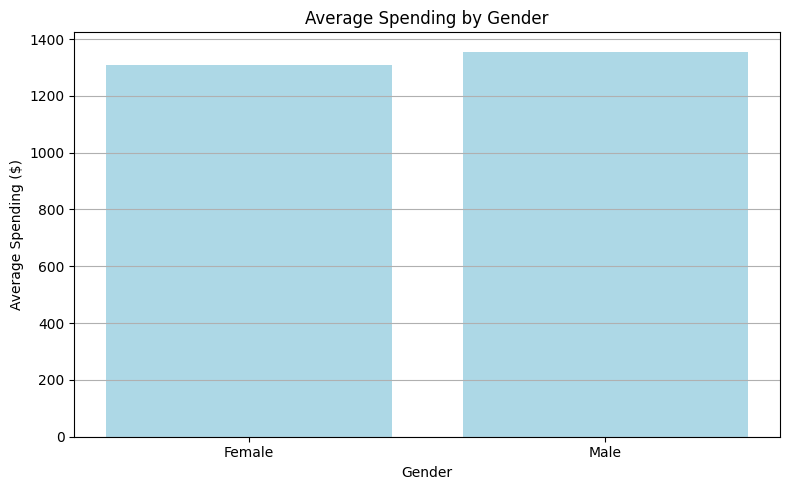

C:\Users\user\AppData\Local\Temp\ipykernel_7844\2950297233.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_age_group = df.groupby('Age Group')['Total Price'].sum().reset_index()


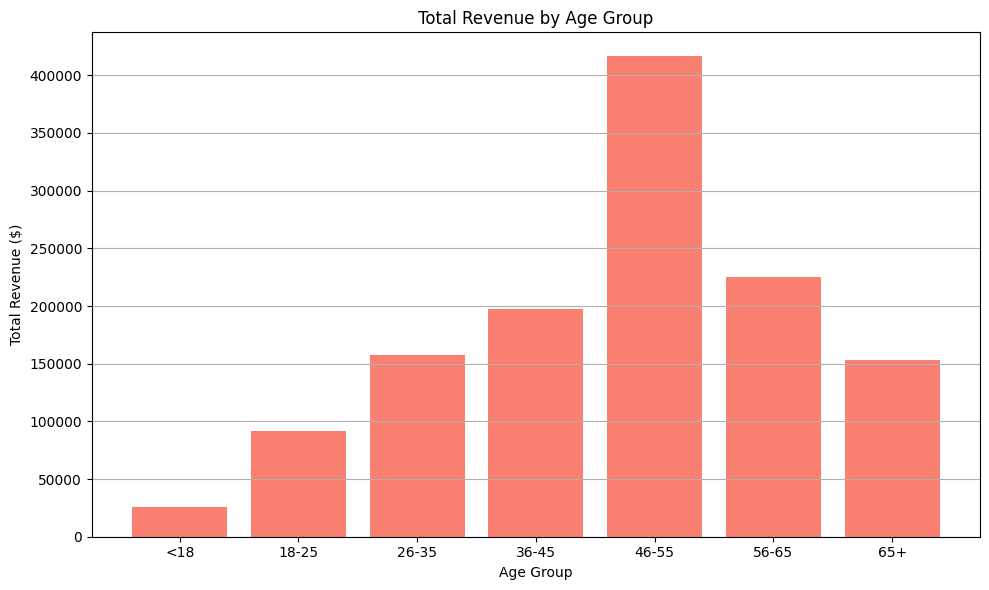

In [66]:
# Let's dive into exploring customer demographics and their purchasing behavior! 
# I want to understand how different demographics influence purchasing decisions.

# First, I'll create a new DataFrame to analyze the average spending by gender.
average_spending_by_gender = df.groupby('Gender')['Total Price'].mean().reset_index()

# Now, let's visualize this data to see if there's a significant difference in spending between genders.
plt.figure(figsize=(8, 5))
plt.bar(average_spending_by_gender['Gender'], average_spending_by_gender['Total Price'], color='lightblue')
plt.title('Average Spending by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Spending ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Next, I want to analyze how age groups affect purchasing behavior.
# I'll create age groups for better analysis.
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

# Now, let's calculate the total revenue by age group.
revenue_by_age_group = df.groupby('Age Group')['Total Price'].sum().reset_index()

# Visualizing the revenue by age group to see which group contributes the most.
plt.figure(figsize=(10, 6))
plt.bar(revenue_by_age_group['Age Group'], revenue_by_age_group['Total Price'], color='salmon')
plt.title('Total Revenue by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Total Revenue ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Through this analysis, I've gained insights into how different demographics impact purchasing behavior. 
# It appears that certain age groups and genders have distinct spending patterns, which can guide our marketing strategies!
# This exploration has been enlightening, and I'm excited to leverage these insights for future campaigns! 🎉


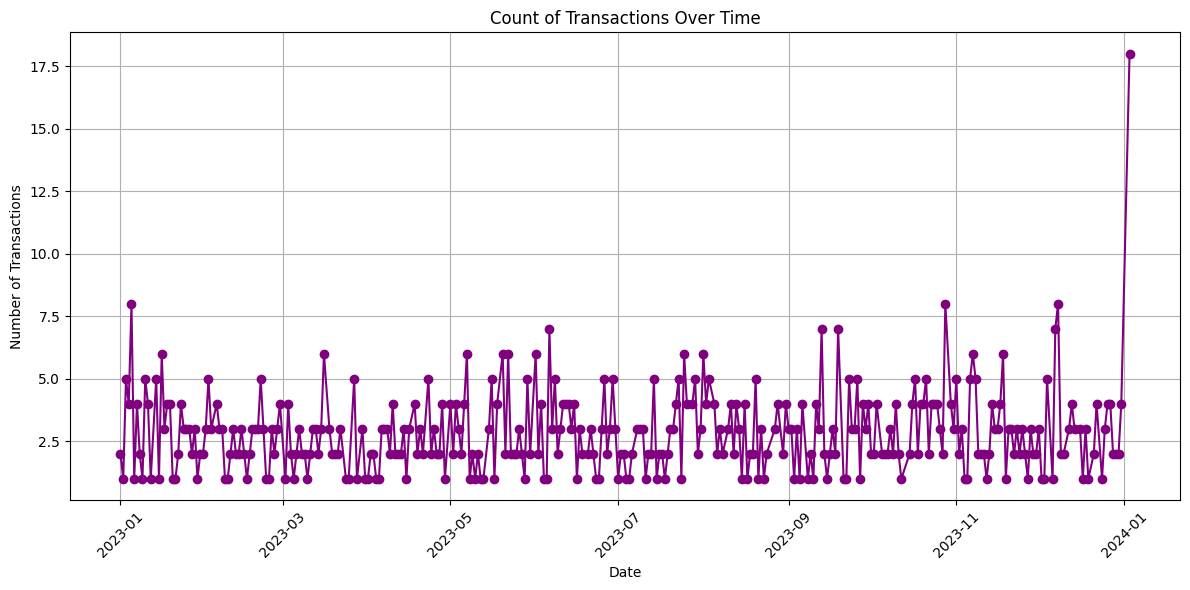

In [67]:
# Wow! Analyzing the count of transactions over time has been a thrilling journey! 📈
# Let's create a line chart to visualize this trend and confirm the validity of our reformatted date column and derived features.

# First, we need to ensure that the 'Order Date' column is in datetime format.
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Now, let's group the data by date and count the number of transactions for each day.
transaction_counts = df.groupby(df['Order Date'].dt.date).size().reset_index(name='Transaction Count')

# Finally, let's plot the line chart to visualize the transaction counts over time.
plt.figure(figsize=(12, 6))
plt.plot(transaction_counts['Order Date'], transaction_counts['Transaction Count'], marker='o', color='purple')
plt.title('Count of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
